<a href="https://colab.research.google.com/github/sskyau/stanford-dogs-classification-models/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Environment Initialisation**

##1.1 Import libraries

In [ ]:
!pip install --upgrade pip
!pip install transformers
!pip list | grep transformers
!pip install transformers datasets
!pip install transformers[onnx]

In [2]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
import pandas as pd

from transformers import ViTFeatureExtractor, ViTModel
from datasets import load_dataset, DatasetDict
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, top_k_accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm 

In [3]:
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


#**2. Model Training**

##2.1 Load pretrained model and feature extractor

In [4]:
model_cp = 'google/vit-base-patch16-224-in21k'

feature_extractor = ViTFeatureExtractor.from_pretrained(model_cp)
model = ViTModel.from_pretrained(model_cp, output_attentions=True)

##2.2 Load dataset

In [5]:
dataset = load_dataset("imagefolder", data_files='http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar')

train_test_dataset = dataset['train'].train_test_split(test_size=0.2)

# Split the 10% test + valid in half test, half valid
test_valid = train_test_dataset['test'].train_test_split(test_size=0.5)

train_test_valid_dataset = DatasetDict({
    'train': train_test_dataset['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

train_ds = train_test_valid_dataset['train'] 
val_ds = train_test_valid_dataset['valid']
test_ds = train_test_valid_dataset['test']

Using custom data configuration default-1e03d00b7bdf2244
Reusing dataset imagefolder (/root/.cache/huggingface/datasets/imagefolder/default-1e03d00b7bdf2244/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff)


  0%|          | 0/1 [00:00<?, ?it/s]

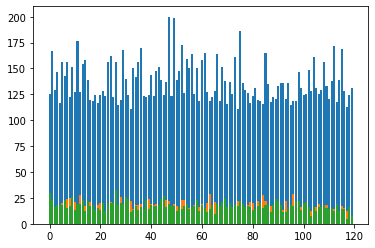

In [6]:
# Visualize distribution of dataset
train_breed_list = [train_ds[dog]['label'] for dog in range(len(train_ds))]
val_breed_list = [val_ds[dog]['label'] for dog in range(len(val_ds))]
test_breed_list = [test_ds[dog]['label'] for dog in range(len(test_ds))]

from collections import Counter

train_breed_count = Counter(train_breed_list)
val_breed_count = Counter(val_breed_list)
test_breed_count = Counter(test_breed_list)

plt.bar(range(len(train_breed_count)), train_breed_count.values(), label='train')
plt.bar(range(len(val_breed_count)), val_breed_count.values(),label='val')
plt.bar(range(len(test_breed_count)), test_breed_count.values(), label='test')
plt.show()

##2.3 Apply image augmentation

In [7]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    RandomRotation,
                                    RandomAutocontrast,
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            CenterCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            RandomRotation(0.1),
            RandomAutocontrast(0.1),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['image'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def test_transforms(examples):
    examples['image'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

train_ds.set_transform(train_transforms)
val_ds.set_transform(test_transforms)
test_ds.set_transform(test_transforms)


##2.4 Define custom model class
Attach a new classification block and define training computations

In [8]:
class StanfordDogsViT(nn.Module):
  def __init__(self, pretrained_vit, class_num):
        super(StanfordDogsViT, self).__init__()
        self.vit = pretrained_vit
        self.fc = nn.Linear(768, class_num)

  def _get_cls_vec(self, states):
        return states['last_hidden_state'][:, 0, :]

  def forward(self, input_ids):
        states = self.vit(input_ids)
        states = self._get_cls_vec(states)
        states = self.fc(states)
        return states

## 2.5 Define training cycle

In [9]:
BATCH_SIZE = 64
CP_DIR = '/content/gdrive/MyDrive/Colab Notebooks/Dissertation/cp/ViT/'

In [10]:
def train_model(epochs, model, trial, es_tolerance, FE):
  
  train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
  val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []
  train_topk_accuracies = []
  val_topk_accuracies = []

  ES_TOLERANCE = es_tolerance
  tolerated = 0
  best_val_acc = 0.0


  for epoch in tqdm(range(epochs)):

    train_loss = 0.0
    train_pred = []
    train_all_pred = []
    train_true = []

    model.train()

    for batch in tqdm(train_loader, position=0, leave=True):
        optimizer.zero_grad()
        input_ids = batch['image'].to(device)
        y = batch['label'].to(device)
        out = model(input_ids)
        loss = loss_cal(out, y)
        loss.backward()
        optimizer.step()

        train_pred += out.argmax(dim=1).cpu().detach().numpy().tolist()
        train_all_pred += out.cpu().detach().numpy().tolist()
        train_true += y.cpu().detach().numpy().tolist()
        train_loss += loss.item()

    
    train_losses.append(train_loss)
    train_acc = accuracy_score(train_true, train_pred)
    train_accuracies.append(train_acc)
    train_topk_acc = top_k_accuracy_score(train_true, train_all_pred, k=5)
    train_topk_accuracies.append(train_topk_acc)


    # calculate validation error and accuracy
    val_loss = 0.0
    val_pred = []
    val_all_pred = []
    val_true = []

    model.eval()

    for batch in tqdm(val_loader, position=0, leave=True):
        with torch.no_grad():

            input_ids = batch['image'].to(device)
            y = batch['label'].to(device)
            out = ViT(input_ids)
            loss = loss_cal(out, y)
            val_loss += loss.item()
            _, y_pred = torch.max(out, 1)            
            val_pred += out.argmax(dim=1).cpu().detach().numpy().tolist()
            val_all_pred += out.cpu().detach().numpy().tolist()
            val_true += y.cpu().detach().numpy().tolist()

    
    val_losses.append(val_loss)
    val_acc = accuracy_score(val_true, val_pred)
    val_accuracies.append(val_acc)
    val_topk_acc = top_k_accuracy_score(val_true, val_all_pred, k=5)
    val_topk_accuracies.append(val_topk_acc)


    # Print progress
    print()
    print('epoch', epoch,
          '\ttrain loss', round(train_loss, 4), '\ttrain accuracy', round(train_acc, 4), '\ttrain top k accuracy', round(train_topk_acc, 4), 
          '\tval loss', round(val_loss, 4), '\tval accuracy', round(val_acc, 4), '\tval top k accuracy', round(val_topk_acc, 4), 
          )
    
    # Early stopping
    if best_val_acc >= val_acc:
      if tolerated == ES_TOLERANCE:
        print('early stopping')
        break
      else:
        tolerated += 1
        print('# epochs w/o improvements', tolerated)
    else:
      tolerated = 0
      best_val_acc = val_acc
      best_epoch = epoch

      # save best model so far
      if FE:
        torch.save(model.state_dict(), CP_DIR + 'FE/FE-' + str(epoch) +'.pth')
      else: 
        torch.save(model.state_dict(), CP_DIR + 'FT/FT-' + str(epoch) +'.pth')

    print('current best val acc: ', best_val_acc)
  
  # plot training history
  plt.figure(figsize=(15,5))

  plt.subplot(1,2,1)
  plt.plot(train_losses, '-o' , label='train loss')
  plt.plot(val_losses, '-^', label='val loss')
  plt.title('loss')
  plt.legend()
  plt.grid()

  plt.subplot(1,2,2)
  plt.plot(train_accuracies, '-o', label='train accuracy')
  plt.plot(val_accuracies, '-^', label='val accuracy')
  plt.title('accuracy')
  plt.legend()
  plt.grid()

  plt.show()

  # save training history
  hist_dict = pd.DataFrame.from_dict({'train_loss': train_losses, 'train_acc': train_accuracies, 'train_topk': train_topk_accuracies, 
             'val_loss': val_losses, 'val_acc': val_accuracies, 'val_topk': val_topk_accuracies})

  if FE:
    logname = CP_DIR + 'FE-' + str(trial) + '.csv'
  else: 
    logname = CP_DIR + 'FT-' + str(trial) + '.csv'

  hist_dict.to_csv(logname, index = False, header=True)

##2.6 Feature extraction

In [15]:
ViT = StanfordDogsViT(model, 120)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ViT.to(device)
loss_cal = nn.CrossEntropyLoss()

trial = 6

100%|██████████| 33/33 [00:25<00:00,  1.29it/s]



epoch 0 	train loss 468.8675 	train accuracy 0.8379 	train top k accuracy 0.9524 	val loss 17.1505 	val accuracy 0.9184 	val top k accuracy 0.9961


  2%|▏         | 1/50 [03:24<2:46:40, 204.10s/it]

current best val acc:  0.9183673469387755


  4%|▍         | 2/50 [06:46<2:42:22, 202.97s/it]


epoch 1 	train loss 117.6502 	train accuracy 0.9021 	train top k accuracy 0.9888 	val loss 11.1329 	val accuracy 0.9184 	val top k accuracy 0.9956
# epochs w/o improvements 1
current best val acc:  0.9183673469387755


  6%|▌         | 3/50 [10:07<2:38:27, 202.28s/it]


epoch 2 	train loss 92.5505 	train accuracy 0.9073 	train top k accuracy 0.9915 	val loss 9.8436 	val accuracy 0.9179 	val top k accuracy 0.9961
# epochs w/o improvements 2
current best val acc:  0.9183673469387755


  8%|▊         | 4/50 [13:25<2:33:47, 200.59s/it]


epoch 3 	train loss 82.7994 	train accuracy 0.9119 	train top k accuracy 0.9928 	val loss 9.3952 	val accuracy 0.9184 	val top k accuracy 0.9956
# epochs w/o improvements 3
current best val acc:  0.9183673469387755


100%|██████████| 33/33 [00:24<00:00,  1.36it/s]



epoch 4 	train loss 76.2049 	train accuracy 0.9178 	train top k accuracy 0.9944 	val loss 9.0762 	val accuracy 0.9213 	val top k accuracy 0.9971


 10%|█         | 5/50 [16:45<2:30:20, 200.46s/it]

current best val acc:  0.9212827988338192


 12%|█▏        | 6/50 [20:04<2:26:31, 199.80s/it]


epoch 5 	train loss 70.9405 	train accuracy 0.9227 	train top k accuracy 0.9951 	val loss 8.9463 	val accuracy 0.9159 	val top k accuracy 0.9961
# epochs w/o improvements 1
current best val acc:  0.9212827988338192


 14%|█▍        | 7/50 [23:23<2:22:58, 199.51s/it]


epoch 6 	train loss 66.0952 	train accuracy 0.9283 	train top k accuracy 0.9961 	val loss 8.9974 	val accuracy 0.9189 	val top k accuracy 0.9966
# epochs w/o improvements 2
current best val acc:  0.9212827988338192


 16%|█▌        | 8/50 [26:41<2:19:16, 198.97s/it]


epoch 7 	train loss 63.0946 	train accuracy 0.9287 	train top k accuracy 0.9965 	val loss 8.9118 	val accuracy 0.914 	val top k accuracy 0.9966
# epochs w/o improvements 3
current best val acc:  0.9212827988338192


 18%|█▊        | 9/50 [30:00<2:15:59, 199.01s/it]


epoch 8 	train loss 58.8498 	train accuracy 0.9345 	train top k accuracy 0.9974 	val loss 8.8481 	val accuracy 0.9159 	val top k accuracy 0.9966
# epochs w/o improvements 4
current best val acc:  0.9212827988338192


 20%|██        | 10/50 [33:18<2:12:32, 198.80s/it]


epoch 9 	train loss 55.4575 	train accuracy 0.9375 	train top k accuracy 0.9977 	val loss 8.9129 	val accuracy 0.915 	val top k accuracy 0.9966
# epochs w/o improvements 5
current best val acc:  0.9212827988338192


 20%|██        | 10/50 [36:37<2:26:31, 219.79s/it]



epoch 10 	train loss 53.0288 	train accuracy 0.9425 	train top k accuracy 0.9981 	val loss 8.9286 	val accuracy 0.9159 	val top k accuracy 0.9961
early stopping


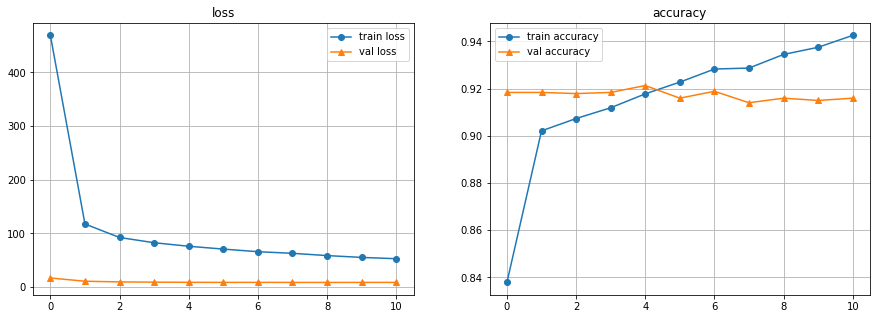

In [41]:
FE_EPOCHS = 50

ES_TOLERANCE = 5


optimizer = optim.Adam([
    {'params': ViT.fc.parameters(), 'lr': 1e-3}
])

# Freeze all 
for param in ViT.parameters():
    param.requires_grad = False

# Unfreeze fully connected layers
for param in ViT.fc.parameters():
    param.requires_grad = True

train_model(FE_EPOCHS, ViT, trial, ES_TOLERANCE, FE=True)

##2.7 Fine-tuning

In [17]:
# Load the best model
ViT.load_state_dict(torch.load("/content/gdrive/MyDrive/Colab Notebooks/Dissertation/cp/ViT/FE/FE-4.pth"))

<All keys matched successfully>

100%|██████████| 33/33 [00:25<00:00,  1.32it/s]



epoch 0 	train loss 71.115 	train accuracy 0.9238 	train top k accuracy 0.9946 	val loss 7.9173 	val accuracy 0.9305 	val top k accuracy 0.9976


  2%|▏         | 1/50 [06:29<5:18:19, 389.78s/it]

current best val acc:  0.9305150631681244


  4%|▍         | 2/50 [12:55<5:10:07, 387.66s/it]


epoch 1 	train loss 64.5197 	train accuracy 0.9289 	train top k accuracy 0.9951 	val loss 7.7698 	val accuracy 0.9291 	val top k accuracy 0.9976
# epochs w/o improvements 1
current best val acc:  0.9305150631681244


100%|██████████| 33/33 [00:25<00:00,  1.30it/s]



epoch 2 	train loss 60.3876 	train accuracy 0.9333 	train top k accuracy 0.9954 	val loss 7.6485 	val accuracy 0.931 	val top k accuracy 0.9976


  6%|▌         | 3/50 [19:22<5:03:05, 386.93s/it]

current best val acc:  0.9310009718172984


  8%|▊         | 4/50 [25:46<4:55:55, 385.98s/it]


epoch 3 	train loss 56.6671 	train accuracy 0.9385 	train top k accuracy 0.9959 	val loss 7.5674 	val accuracy 0.931 	val top k accuracy 0.9976
# epochs w/o improvements 1
current best val acc:  0.9310009718172984


100%|██████████| 33/33 [00:24<00:00,  1.35it/s]



epoch 4 	train loss 53.1796 	train accuracy 0.9433 	train top k accuracy 0.996 	val loss 7.5106 	val accuracy 0.9325 	val top k accuracy 0.9976


 10%|█         | 5/50 [32:12<4:49:28, 385.96s/it]

current best val acc:  0.9324586977648203


 12%|█▏        | 6/50 [38:35<4:42:22, 385.07s/it]


epoch 5 	train loss 50.3149 	train accuracy 0.9467 	train top k accuracy 0.9962 	val loss 7.4894 	val accuracy 0.9315 	val top k accuracy 0.9976
# epochs w/o improvements 1
current best val acc:  0.9324586977648203


100%|██████████| 33/33 [00:25<00:00,  1.28it/s]



epoch 6 	train loss 47.6965 	train accuracy 0.9506 	train top k accuracy 0.9961 	val loss 7.4471 	val accuracy 0.9334 	val top k accuracy 0.9976


 14%|█▍        | 7/50 [45:02<4:36:16, 385.50s/it]

current best val acc:  0.9334305150631681


100%|██████████| 33/33 [00:24<00:00,  1.32it/s]



epoch 7 	train loss 44.8083 	train accuracy 0.9555 	train top k accuracy 0.9961 	val loss 7.4277 	val accuracy 0.9349 	val top k accuracy 0.9976


 16%|█▌        | 8/50 [51:30<4:30:31, 386.47s/it]

current best val acc:  0.93488824101069


100%|██████████| 33/33 [00:25<00:00,  1.31it/s]



epoch 8 	train loss 42.822 	train accuracy 0.9575 	train top k accuracy 0.9968 	val loss 7.4184 	val accuracy 0.9354 	val top k accuracy 0.9976


 18%|█▊        | 9/50 [58:01<4:24:54, 387.67s/it]

current best val acc:  0.935374149659864


 20%|██        | 10/50 [1:04:28<4:18:23, 387.58s/it]


epoch 9 	train loss 40.5725 	train accuracy 0.9597 	train top k accuracy 0.9968 	val loss 7.4453 	val accuracy 0.9344 	val top k accuracy 0.9976
# epochs w/o improvements 1
current best val acc:  0.935374149659864


 22%|██▏       | 11/50 [1:10:53<4:11:25, 386.81s/it]


epoch 10 	train loss 38.4258 	train accuracy 0.9626 	train top k accuracy 0.997 	val loss 7.4221 	val accuracy 0.9354 	val top k accuracy 0.9971
# epochs w/o improvements 2
current best val acc:  0.935374149659864


100%|██████████| 33/33 [00:24<00:00,  1.34it/s]



epoch 11 	train loss 36.315 	train accuracy 0.9639 	train top k accuracy 0.9974 	val loss 7.4268 	val accuracy 0.9359 	val top k accuracy 0.9976


 24%|██▍       | 12/50 [1:17:19<4:04:51, 386.62s/it]

current best val acc:  0.9358600583090378


 26%|██▌       | 13/50 [1:23:44<3:58:03, 386.04s/it]


epoch 12 	train loss 34.8601 	train accuracy 0.9664 	train top k accuracy 0.9976 	val loss 7.4483 	val accuracy 0.9344 	val top k accuracy 0.9971
# epochs w/o improvements 1
current best val acc:  0.9358600583090378


 28%|██▊       | 14/50 [1:30:09<3:51:22, 385.62s/it]


epoch 13 	train loss 32.9473 	train accuracy 0.9682 	train top k accuracy 0.9978 	val loss 7.4747 	val accuracy 0.9349 	val top k accuracy 0.9961
# epochs w/o improvements 2
current best val acc:  0.9358600583090378


 30%|███       | 15/50 [1:36:34<3:44:51, 385.47s/it]


epoch 14 	train loss 31.1095 	train accuracy 0.9698 	train top k accuracy 0.9977 	val loss 7.4903 	val accuracy 0.9349 	val top k accuracy 0.9961
# epochs w/o improvements 3
current best val acc:  0.9358600583090378


 32%|███▏      | 16/50 [1:42:57<3:38:02, 384.77s/it]


epoch 15 	train loss 29.7429 	train accuracy 0.9718 	train top k accuracy 0.9978 	val loss 7.5012 	val accuracy 0.9359 	val top k accuracy 0.9961
# epochs w/o improvements 4
current best val acc:  0.9358600583090378


 34%|███▍      | 17/50 [1:49:20<3:31:23, 384.36s/it]


epoch 16 	train loss 28.2169 	train accuracy 0.9732 	train top k accuracy 0.9985 	val loss 7.5273 	val accuracy 0.9354 	val top k accuracy 0.9961
# epochs w/o improvements 5
current best val acc:  0.9358600583090378


 34%|███▍      | 17/50 [1:55:46<3:44:44, 408.63s/it]



epoch 17 	train loss 26.8206 	train accuracy 0.9747 	train top k accuracy 0.9985 	val loss 7.5692 	val accuracy 0.9339 	val top k accuracy 0.9961
early stopping


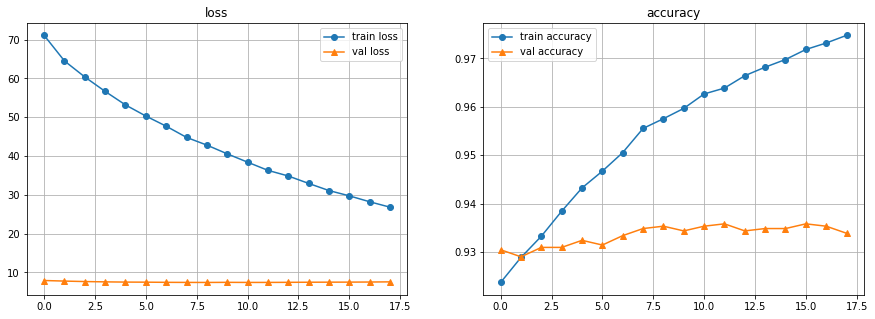

In [18]:
FT_EPOCHS = 50

ES_TOLERANCE = 5

optimizer = optim.Adam([
    {'params': ViT.parameters(), 'lr': 1e-6}
])

# Unfreeze  layers
for param in ViT.vit.parameters():
    param.requires_grad = True

train_model(FT_EPOCHS, ViT, trial, ES_TOLERANCE, FE=False)

# **3. Model Testing**

In [21]:
# Load the best model
ViT.load_state_dict(torch.load("/content/gdrive/MyDrive/Colab Notebooks/Dissertation/cp/ViT/FT/FT-11.pth"))

<All keys matched successfully>

In [22]:
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

test_loss = 0.0
test_pred = []
test_all_pred = []
test_true = []
ViT.eval()

for batch in tqdm(test_loader, position=0, leave=True):
    with torch.no_grad():

        input_ids = batch['image'].to(device)
        y = batch['label'].to(device)
        out = ViT(input_ids)
        loss = loss_cal(out, y)
        test_loss += loss.item()
        _, y_pred = torch.max(out, 1)            
        test_pred += out.argmax(dim=1).cpu().detach().numpy().tolist()
        test_all_pred += out.cpu().detach().numpy().tolist()
        test_true += y.cpu().detach().numpy().tolist()


test_acc = accuracy_score(test_true, test_pred)
test_topk_acc = top_k_accuracy_score(test_true, test_all_pred, k=5)

print(
  '\ttest loss', round(test_loss, 4), '\ttest accuracy', round(test_acc, 4), '\ttest top k accuracy', round(test_topk_acc, 4), 
  )

100%|██████████| 33/33 [00:25<00:00,  1.31it/s]

	test loss 7.5081 	test accuracy 0.932 	test top k accuracy 0.9956


In [23]:
torch.save(ViT, CP_DIR+'final.pt')